In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN, KMeans
import clustergraph.clustergraph as cg
import clustergraph.distances as d
from clustergraph.Metric_distortion_class import Metric_distortion
from clustergraph.c_GraphPreprocess import GraphPreprocess

data = pd.read_csv("data/noisy_circles.csv", sep=",", header=None)
X = data.to_numpy()
print(X.shape)

model_KM = KMeans(20, random_state=42)
prediction_KM = model_KM.fit_predict(X)

model_DB = DBSCAN(eps=0.2, min_samples=5)
predict_DB = model_DB.fit_predict(X)
X1 = X[predict_DB == 0]
X2 = X[predict_DB == 1]
colors = []

# Get one cluster per circle in order to have the corresponding labels
for i in range(len(predict_DB)):
    if predict_DB[i] == 0:
        colors.append("#3182bd")
    else:
        colors.append("#a1d99b")

labels_circles = np.array(colors)
print(np.unique(predict_DB))

nb = 10
neigh = NearestNeighbors(n_neighbors=nb, radius=1)
neigh.fit(X=X)
nn_adjacency = neigh.kneighbors_graph(X=X, n_neighbors=nb, mode="distance")
nn_Graph = nx.from_scipy_sparse_array(nn_adjacency, edge_attribute="label")

for node in nn_Graph.nodes:
    nn_Graph.remove_edge(node, node)

print("Number connected components : ", nx.number_connected_components(nn_Graph))

(500, 2)


C:\Users\mathi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\mathi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


[0 1]
Number connected components :  2


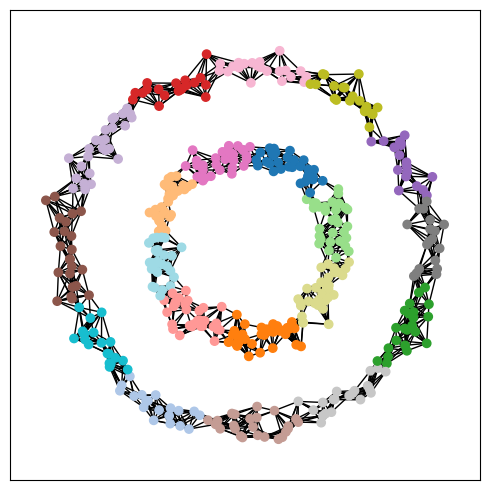

In [2]:
fig, ax = plt.subplots(figsize=(5, 5))
nx.draw_networkx_edges(
    nn_Graph,
    pos={i: p for i, p in enumerate(X)},
    ax=ax,
)
ax.scatter(X[:, 0], X[:, 1], c=prediction_KM, cmap="tab20")
ax.axis("equal")

plt.tight_layout()
#plt.savefig("circles_kmeans.pdf")
plt.show()

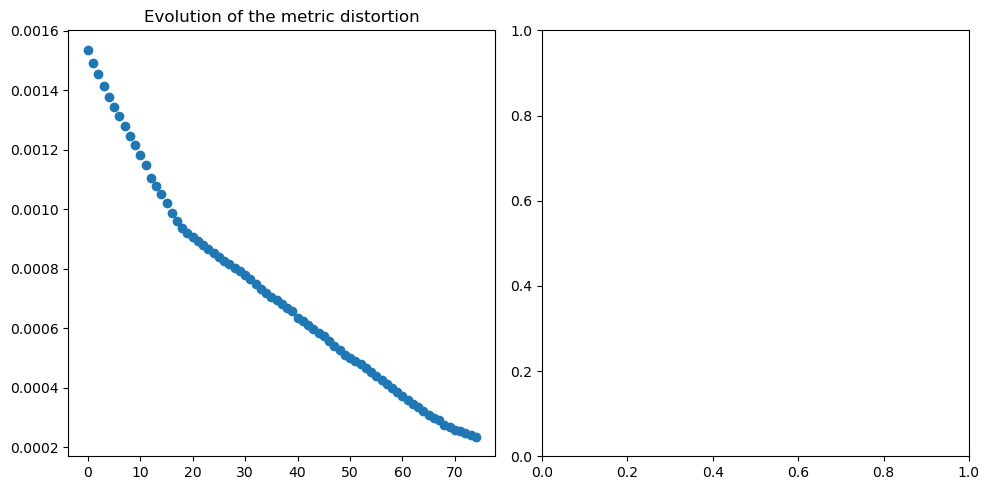

In [3]:
from clustergraph.utils import get_clusters_from_scikit
cluster_g = cg.ClusterGraph(clusters=get_clusters_from_scikit(prediction_KM), 
                            X=X, 
                            metric_clusters="average",
                            type_pruning="md", 
                            knn_g=nn_Graph)

# Coloring the graph
cluster_g.fit_graph(node_type_coloring="label", node_color_labels=prediction_KM, node_palette=cm.get_cmap("tab20"))

# Distortion pruning
metric_distortion_graph, md=cluster_g.prune_distortion(nn_Graph, score=True)

# Connectivity pruning
#connectivity_graph, conn=cluster_g.prune_conn(score=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.scatter(range(len(md)), md)
ax1.set_title("Evolution of the metric distortion")

#ax2.scatter(range(len(conn)), conn)
#ax2.set_title("Evolution of the connectivity")

plt.tight_layout()
plt.show()

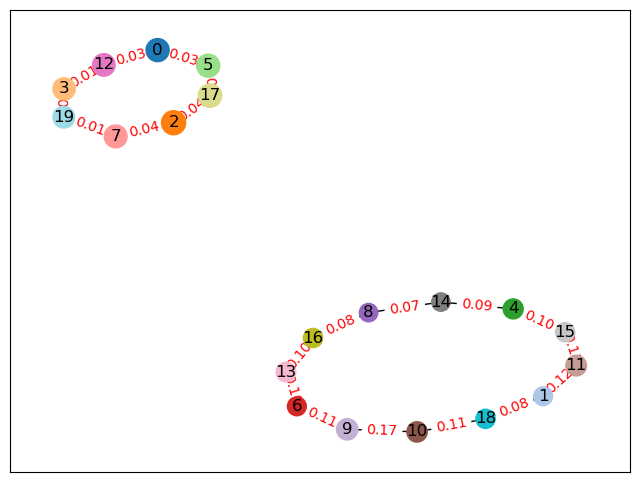

In [5]:
import clustergraph.plot_graph as pg
pg.plot_colored_graph(metric_distortion_graph, size_nodes=1000, random_state=42)

# Graph after the metric distortion pruning

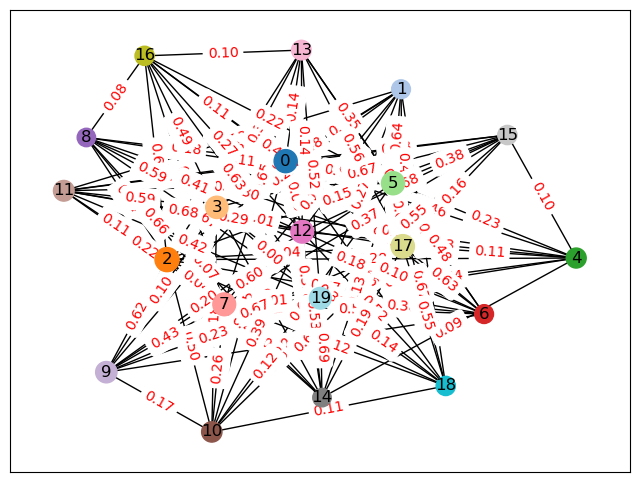

In [6]:
import clustergraph.plot_graph as pg
metric_distortion_graph = cluster_g.prune_distortion(nn_Graph)
pg.plot_colored_graph(metric_distortion_graph, size_nodes=1000, random_state=42)

### Merge of disconnected components

In [ ]:
merged_graph = cluster_g.merge_graph()
pg.plot_colored_graph(merged_graph, size_nodes=1000, random_state=42)

### Graph with 0.99% of the connectivity kept

In [ ]:
import clustergraph.plot_graph as pg
connectivity_graph=cluster_g.prune_conn(nb_edge_pruned=155)
pg.plot_colored_graph(connectivity_graph, size_nodes=1000, random_state=42)

# Other graphs

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
graph = g_prepro.graph
pos = nx.spring_layout(g, seed=42)

for edge in graph.edges(data=True):
    if edge[0] == 3 or edge[1] == 3:
        print("edge", edge)
    edge[2]["label"] = round(edge[2]["label"], 2)


labels = nx.get_edge_attributes(graph, "label")
nx.draw_networkx(
    graph,
    pos,
    with_labels=True,
    font_weight="bold",
    node_color=[n[1]["color"] for n in graph.nodes(data=True)],
    ax=ax,
)
nx.draw_networkx_edge_labels(graph, pos, label_pos=0.5, edge_labels=labels, ax=ax)
plt.tight_layout()
#plt.savefig("circles_pruned.pdf")
plt.show()

## Merge components 

In [ ]:
%%time
cluster_g = cg.ClusterGraph(
    clusters=get_clusters_from_scikit(prediction_KM), X=X, metric_clusters="average"
)

from clustergraph.GraphPruning import GraphPruning
gp = GraphPruning(cluster_g.graph, type_pruning = "md", knn_g= nn_Graph, algo="bf",  k_compo = 3)
pruned_gg, md = gp.prune(score = True)

graph_con = gp.prunedStrategy.conn_prune_merged_graph( pruned_gg, nb_edges_pruned = 20 )
gp.prunedStrategy.plt_conn_prune_computed()

Plot of the graph with :

1- The metric distortion leading to two disconnected circle

2- Connecting the 3 nearest nodes (in different components) and applying a connectivity pruning only on those edges

In [ ]:
g_prepro_conn = GraphPreprocess(graph_con)
g_prepro_conn.fit_nodes(
    type_coloring="label", color_labels=prediction_KM, palette=cm.get_cmap("tab20")
)
g_prepro_conn.fit_edges()
g_conn = g_prepro_conn.graph

import clustergraph.plot_graph as pg
pg.plot_colored_graph(g_conn, nb_edges=len(g_conn.edges), size_nodes=1000, random_state = 42)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

g_conn = g_prepro_conn.graph

pos = nx.spring_layout(g_conn, seed=42)

for edge in g_conn.edges(data=True):
    edge[2]["label"] = round(edge[2]["label"], 2)


labels = nx.get_edge_attributes(g_conn, "label")
nx.draw_networkx(
    g_conn,
    pos,
    with_labels=True,
    font_weight="bold",
    node_color=[n[1]["color"] for n in g_conn.nodes(data=True)],
    ax=ax,
)
nx.draw_networkx_edge_labels(g_conn, pos, label_pos=0.5, edge_labels=labels, ax=ax)
plt.tight_layout()
# plt.savefig("circles_merged.pdf")
plt.show()

## plot all

In [ ]:
fig, axs = plt.subplots(figsize=(13.5, 4.5), ncols=3)

nx.draw_networkx_edges(
    nn_Graph,
    pos={i: p for i, p in enumerate(X)},
    alpha=0.4,
    ax=axs[0],
)
axs[0].scatter(X[:, 0], X[:, 1], c=prediction_KM, cmap="tab20")
axs[0].axis("equal")
axs[0].set_title("(a)", fontname="serif", family="cmr10", size=18)

graph = g_prepro.graph
pos = nx.spring_layout(g, seed=42)

for edge in graph.edges(data=True):
    if edge[0] == 3 or edge[1] == 3:
        print("edge", edge)
    edge[2]["label"] = round(edge[2]["label"], 2)


labels = nx.get_edge_attributes(graph, "label")
nx.draw_networkx(
    graph,
    pos,
    with_labels=True,
    font_weight="bold",
    node_color=[n[1]["color"] for n in graph.nodes(data=True)],
    ax=axs[1],
)
nx.draw_networkx_edge_labels(graph, pos, label_pos=0.5, edge_labels=labels, ax=axs[1])
axs[1].set_title("(b)", fontname="serif", family="cmr10", size=18)


g_conn = g_prepro_conn.graph
pos = nx.spring_layout(g_conn, seed=42)

for edge in g_conn.edges(data=True):
    edge[2]["label"] = round(edge[2]["label"], 2)

labels = nx.get_edge_attributes(g_conn, "label")
nx.draw_networkx(
    g_conn,
    pos,
    with_labels=True,
    font_weight="bold",
    node_color=[n[1]["color"] for n in g_conn.nodes(data=True)],
    ax=axs[2],
)
nx.draw_networkx_edge_labels(g_conn, pos, label_pos=0.5, edge_labels=labels, ax=axs[2])
axs[2].set_title("(c)", fontname="serif", family="cmr10", size=18)


plt.tight_layout()
plt.subplots_adjust(wspace=0.17)
#plt.savefig("concentric_circles.pdf")
plt.show()